# **FINAL PROJECT FTDSH8 #003**

## **INTRODUCTION**

- Nama    : Rafif Aditio
- Batch   : 003
- Topic   : Text Summarization

Dataset yang digunakan pada Notebook ini dapat diunduh di [link](https://www.kaggle.com/farhan999/tokopedia-product-reviews).

Pada Notebook ini akan dilakukan summarization dari produk review pada salah satu marketplace online. Adapun pada proses pembuatan model akan digunakan tiga algoritma, yaitu:
1. Pre-trained BERTmodel for extractive Summarization
2. Pre-trained Pegasus model for abstractive Summarization
3. TextRank similarity for extractive Summarization

## **IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk import tokenize
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

import networkx as nx
import codecs
from summarizer import Summarizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

## **DATA LOADING**

In [2]:
df = pd.read_csv('product_reviews_dirty.csv', index_col='Unnamed: 0').reset_index(drop=True)

In [3]:
df.head()

,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...


In [4]:
df.shape

(40607, 8)

In [5]:
df[df.duplicated()].shape

(0, 8)

In [6]:
df.isnull().sum()

text             0
rating           0
category         0
product_name     0
product_id       0
sold            14
shop_id          0
product_url      0
dtype: int64

Tidak ditemukan data duplikat pada dataset.

Terdapat 14 missing value pada kolom `sold`. Semejak kolom tersebut tidak digunakan pada pemrosesan maka dapat diabaikan.

## **DATA CLEANING**

Penelitian pada notebook ini hhanya akan berfokus pada satu tipe produk saja. Dalam pemilihan produk pertimbangan yang digunakan ialah yang memiliki jumlah rating 1 dan 2 terbanyak.

In [7]:
df.product_name.value_counts()

TINTA / CATRIDGE HP 680 BLACK / COLOR ORIGINAL 100%                           1312
Gamepad single Usb M-Tech/stick laptop/stick pc/joystick                      1113
USB HUB 4 port USB 3.0 / USB HUB 3.0 &#40;4port&#41; DIGIGEAR HIGH QUALITY    1110
TINTA / CATRIDGE HP 678 BLACK / COLOR ORIGINAL 100%                            791
Switch HUB TP LINK 5 Port TL-SF1005D 10/100Mbps Network Lan Internet           763
                                                                              ... 
BATA Sandal Pria PIETE 8633076 - Cokelat Muda, 39                                1
Xiaomi Redmi Note 4X 4 / 64 Rose Gold / Pink                                     1
MOC3023 6 Pin Triac OptoIsolator Dip-6 BF99                                      1
Headband Bayi Perempuan Tamagoo-Flora Denim Aksesoris Baby Lucu Murah            1
RHYTHM F1504R01 Jam Tangan Wanita                                                1
Name: product_name, Length: 3647, dtype: int64

In [8]:
df.rating.value_counts()

5    30311
4     7546
3     1825
1      543
2      382
Name: rating, dtype: int64

Pada Notebook ini akan berfokus pada salah satu tipe produk saja. Dalam memilih jenis produk yang akan dianalisis, digunakan pertimbangan jumlah entry data terbanyak pada label sentimen negatif atau rating 1 dan 2.

In [9]:
df_bad = df[df.rating<=2]

In [10]:
df_bad.product_name.value_counts()

Headset Bluetooth Mini S530 - Micro Sport Stereo Bluetooth Earphone       83
NOKIA 130 dual sim handphone hp                                           80
Samsung lipat flip Caramel GT-E1272 samsung hp murah handphone baru       25
Gamepad single Usb M-Tech/stick laptop/stick pc/joystick                  18
Sepatu Casual Kets Sport Nike MD Runner / Waffle Trainer Hitam Putih      18
                                                                          ..
BUBBLE GUMMERS Sepatu Anak Laki-Laki YOMAN BLUE 3619415 - 29               1
Adaptor Charger Laptop Asus 20V 3.25A/15V-3A/12V-3A/9V-2A/5V-2A USB-C      1
Dental Light WhiteLight 20 Minute / Pemutih GIGI White LIGHT WHITENING     1
Target Pukul Double For Taekwondo Karate                                   1
Headset / Earphone Xiaomi Type MH133 OEM Berkualitas                       1
Name: product_name, Length: 452, dtype: int64

Produk `Headset Bluetooth Mini S530 - Micro Sport Stereo Bluetooth Earphone` memiliki jumlah label 1 dan 2 terbanyak. Maka diputuskan produk tersebut yang akan digunakan dalam Notebook ini.

In [11]:
df_hds = df[df.product_name=='Headset Bluetooth Mini S530 - Micro Sport Stereo Bluetooth Earphone']

In [12]:
df_hds = df_hds[['product_name', 'text', 'rating']].reset_index(drop=True)

Dalam Notebook ini, review akan dikelompokkan menjadi 3 sentimen, yaitu: negatif(0), netral(1), dan positif(2).

Sebelum dilakukan proses lebih lanjut, akan disiapkan terlebih dahulu pelabelan sentimen pada entry data.

In [13]:
df_hds['sentimen'] = df_hds['rating'].replace({1:0, 2:0, 3:1, 4:2, 5:2})

In [14]:
df_hds.sample(10)

,product_name,text,rating,sentimen
518,Headset Bluetooth Mini S530 - Micro Sport Ster...,Thankyou Barang sudah sampai ke customer,4,2
26,Headset Bluetooth Mini S530 - Micro Sport Ster...,Ukuran dan warna sesuai foto,4,2
230,Headset Bluetooth Mini S530 - Micro Sport Ster...,Barang dah sampai...terimakasih,4,2
460,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Packing rapi, ditrima kondisi bagus, di charge...",1,0
149,Headset Bluetooth Mini S530 - Micro Sport Ster...,Baterai gampang habis padahal sudah dicas full,2,0
693,Headset Bluetooth Mini S530 - Micro Sport Ster...,TOP Juragan.. Recommended seller dah........,5,2
235,Headset Bluetooth Mini S530 - Micro Sport Ster...,Xxkxksjcxixj jsidkcksksi ksiskxiisi ksksisi,5,2
647,Headset Bluetooth Mini S530 - Micro Sport Ster...,baru 1 hari pake udah ga nyala,1,0
500,Headset Bluetooth Mini S530 - Micro Sport Ster...,"barang oke, cuman agak kurang pas ditelinga saya",4,2
337,Headset Bluetooth Mini S530 - Micro Sport Ster...,Sesuai dengan harganya,3,1


## **DATA PREPROCESSING**

Salah satu challange dalam melakukan pemrosesan teks bahasa indonesia ialah keberadaan bahasa slang atau bahasa gaul/alay yang biasa digunakan dalam keseharian. Salah satu cara mentransformasi hal ini digunakan kamus bahasa alay atau Colloquial Indonesian Lexicon yang telah dibuat oleh Nikmatun Aliyah Salsabila. Paper publikasi pada kamus ini dapat dilihat di [link](https://ieeexplore.ieee.org/abstract/document/8629151).

In [15]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
diksi = pd.read_csv('diksi_summarization.csv')

In [16]:
kamus_alay.sample(10)

,slang,formal,In-dictionary,context,category1,category2,category3
2098,kpleset,kepleset,1,semut jg kpleset itu? @fikriyyahnf,abreviasi,0,0
9231,yg,yang,1,Ka... hidup d dunia cuma smentara ka... bahagi...,abreviasi,0,0
14365,wowww,wow,1,wowww,elongasi,0,0
10469,anak2,anak-anak,1,SEPATU MURAH DAN BERKUALITAS untuk pria/wanita...,reduplikasi,0,0
892,pngen,pengin,1,Kapan sih episode yang ini..sudh ga sbr pngen ...,abreviasi,modifikasi vokal,0
930,adengan,adegan,1,@dessyriani93 @krishidayatul_a @_ibelova234_ @...,anaptiksis,0,0
3909,org,orang,1,Hanya org yg beriman yg bisa memahami jd kamu ...,abreviasi,0,0
77,kharismanya,karismanya,1,@ariel_nazril_irham bener2 kharismanya harga m...,anaptiksis,0,0
1190,nanggepin,menanggapi,1,Nau apa sih suka dukanya kalau jadi penyanyi k...,afiksasi,0,0
1933,mmbodohkan,membodohkan,1,"@avry_sitohang ,lu tau prjuangan kd,....nyanyi...",abreviasi,0,0


In [17]:
kamus_alay.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [18]:
# Melihat 10 data awal
dict_alay = pd.Series(kamus_alay.formal.values,index=kamus_alay.slang).to_dict()
dict_alay['brg'] = 'barang'
dict_alay['kw']='tiruan'
dict(list(dict_alay.items())[:10])


{'woww': 'wow',
 'aminn': 'amin',
 'met': 'selamat',
 'netaas': 'menetas',
 'keberpa': 'keberapa',
 'eeeehhhh': 'eh',
 'kata2nyaaa': 'kata-katanya',
 'hallo': 'halo',
 'kaka': 'kakak',
 'ka': 'kak'}

In [19]:
# Melihat 10 data awal
diksi = pd.Series(diksi.formal.values,index=diksi.slang).to_dict()
dict(list(diksi.items())[:10])

{'tq': 'terima kasih',
 'thx': 'terima kasih',
 'tkx': ' terima kasih',
 'thk': ' terima kasih',
 'makash': 'terima kasih',
 'tks': 'terima kasih',
 'tls': 'terima kasih',
 'thanks': 'terima kasih',
 'thankks': 'terima kasih',
 'thnq': 'terima kasih'}

In [20]:
# remove unnecessary characters and transforming colloquial word to its common form
def clean_text(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"    # emoticons
        u"\U0001F300-\U0001F5FF"    # symbols & pictographs
        u"\U0001F680-\U0001F6FF"    # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
        u"\U00002500-\U00002BEF"    # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                   # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

    text = text.lower()                                                             # membuat huruf menjadi kecil
    text = re.sub(emoj, '', text)                                                   # remove emoji
    text = re.sub(r'(.)\1{2,}', r'\1', text)                                        # mengubah huruf berulang diatas 2 kali menjadi 1 saja
    text = re.sub("[0-9]", " ", text)                                               # remove numbers
    text = re.sub("'s", " ", text) 
    text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)                                 # remove power character
    text = re.sub("[^\w\s]*[_,.!?#&;:><+-/)/(\'\"]", " ", text)                     # remove bukan string dan whitespace
    text = ' '.join([re.sub(r'nya$|ny$', '', i) for i in text.split()])             # menghapus akhir kata 'nya' atau 'ny'
    text = " ".join(dict_alay[w] if w in dict_alay else w for w in text.split())    # replace sesuai dict_alay
    text = " ".join(diksi[w] if w in diksi else w for w in text.split())            # replace sesuai diksi
    text = re.sub(" +", " ", text.strip())                                          # Remove unnecessary white space
    return text

def cleaner(df):
    df['preprocessed'] = df['text'].apply(clean_text)
    return df

cleaner(df_hds)

df_hds.head()

,product_name,text,rating,sentimen,preprocessed
0,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Produk sesuai dengan deskripsi, berfungsi deng...",5,2,produk sesuai dengan deskripsi berfungsi denga...
1,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Barang bagus, tinggal liat durabiliti nya",3,1,barang bagus tinggal lihat durabiliti
2,Headset Bluetooth Mini S530 - Micro Sport Ster...,Semoga bagus suaranya.....,4,2,semoga bagus suara
3,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Barangnya bagus, pengiriman cepat...",5,2,barang bagus pengiriman cepat
4,Headset Bluetooth Mini S530 - Micro Sport Ster...,Semoga awet thk gan sukses,4,2,semoga awet terima kasih gan sukses


In [21]:
for i in list(np.random.randint(0,len(df_hds),5)):
    print('Original: ', df_hds.iloc[i,1])
    print('Preprocessed: ', df_hds.iloc[i,4])
    print('-'*50)

Original:  Barang bagus bos, Hny bintang yg bisa menilai...
Preprocessed:  barang bagus bos h bintang yang bisa menilai
--------------------------------------------------
Original:  thanks..sukses selalu............................................
Preprocessed:  terima kasih sukses selalu
--------------------------------------------------
Original:  barang udah nyampe. .kualitas oke
Preprocessed:  barang sudah sampai kualitas oke
--------------------------------------------------
Original:  penjualnya kurang peka terhadap komplainan dari CS sehingga mengecewakan pelanggan
Preprocessed:  penjual kurang peka terhadap komplainan dari cs sehingga mengecewakan pelanggan
--------------------------------------------------
Original:  ok,.............................
Preprocessed:  ok
--------------------------------------------------


In [22]:
# Menghilangkan stopword dan imbuhan
def stemmer_stopword(text):
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    text = stemmer.stem(text)

    list_stopwords = set(stopwords.words('indonesian'))                             # stopword from nltk
    stopword_factory = StopWordRemoverFactory()                                     # stopword from sastrawi
    stopwords_sastrawi = set(stopword_factory.get_stop_words()) 
    list_stopwords = list_stopwords.union(stopwords_sastrawi)                       # join both stopword

    list_stopwords.remove('enggak')                                                 # remove 'enggak' dan 'tidak' from list_stopwords
    list_stopwords.remove('tidak')

    text = " ".join(w if w not in list_stopwords else '' for w in text.split())
    text = re.sub(" +", " ", text.strip())                                          # Remove unnecessary white space
    return text

def clean_stopword(df):
    df['removed stopword'] = df['preprocessed'].apply(stemmer_stopword)
    return df

clean_stopword(df_hds)

df_hds.head()

,product_name,text,rating,sentimen,preprocessed,removed stopword
0,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Produk sesuai dengan deskripsi, berfungsi deng...",5,2,produk sesuai dengan deskripsi berfungsi denga...,produk sesuai deskripsi fungsi harga murah tid...
1,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Barang bagus, tinggal liat durabiliti nya",3,1,barang bagus tinggal lihat durabiliti,barang bagus tinggal lihat durabiliti
2,Headset Bluetooth Mini S530 - Micro Sport Ster...,Semoga bagus suaranya.....,4,2,semoga bagus suara,moga bagus suara
3,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Barangnya bagus, pengiriman cepat...",5,2,barang bagus pengiriman cepat,barang bagus kirim cepat
4,Headset Bluetooth Mini S530 - Micro Sport Ster...,Semoga awet thk gan sukses,4,2,semoga awet terima kasih gan sukses,moga awet terima kasih gan sukses


Menghilangkan hasil transformasi redundant berupa whitespace

In [23]:
df_hds[df_hds['removed stopword']=='']

,product_name,text,rating,sentimen,preprocessed,removed stopword
287,Headset Bluetooth Mini S530 - Micro Sport Ster...,🔧........................,1,0,,
294,Headset Bluetooth Mini S530 - Micro Sport Ster...,ok...................,4,2,ok,
385,Headset Bluetooth Mini S530 - Micro Sport Ster...,OK.......................................,5,2,ok,
461,Headset Bluetooth Mini S530 - Micro Sport Ster...,................................................n,5,2,dan,
504,Headset Bluetooth Mini S530 - Micro Sport Ster...,..............................,3,1,,
626,Headset Bluetooth Mini S530 - Micro Sport Ster...,ok.........................................,5,2,ok,
627,Headset Bluetooth Mini S530 - Micro Sport Ster...,okkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,4,2,ok,
632,Headset Bluetooth Mini S530 - Micro Sport Ster...,ok.................. .. . ............,5,2,ok,
652,Headset Bluetooth Mini S530 - Micro Sport Ster...,ok....................................,5,2,ok,
660,Headset Bluetooth Mini S530 - Micro Sport Ster...,"ok,.............................",3,1,ok,


In [24]:
df_hds['removed stopword'] = df_hds['removed stopword'].replace('',np.nan)

In [25]:
df_hds.dropna(inplace=True)

In [26]:
df_hds.sample(10)

,product_name,text,rating,sentimen,preprocessed,removed stopword
297,Headset Bluetooth Mini S530 - Micro Sport Ster...,barang tidak sampai sma sekali,1,0,barang tidak sampai sama sekali,barang tidak
539,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Kualitas barang sangat buruk, not recomended",1,0,kualitas barang sangat buruk not recomended,kualitas barang buruk not recomended
193,Headset Bluetooth Mini S530 - Micro Sport Ster...,Terimakasih gan. brg yg agan kirim berfungsi d...,5,2,terimakasih gan barang yang agan kirim berfung...,terimakasih gan barang agan kirim fungsi moga ...
106,Headset Bluetooth Mini S530 - Micro Sport Ster...,Qualitas suara bagus sekali untuk harga yg dit...,4,2,qualitas suara bagus sekali untuk harga yang d...,qualitas suara bagus harga tawar tinggal coba
694,Headset Bluetooth Mini S530 - Micro Sport Ster...,barangnya bagus gan pengiriman cepat maaf baru...,5,2,barang bagus gan pengiriman cepat maaf baru ko...,barang bagus gan kirim cepat maaf konfirmasi h...
480,Headset Bluetooth Mini S530 - Micro Sport Ster...,barang sdh smpai & berfungsi.,3,1,barang sudah sampai berfungsi,barang fungsi
581,Headset Bluetooth Mini S530 - Micro Sport Ster...,tq.................................,4,2,terima kasih,terima kasih
169,Headset Bluetooth Mini S530 - Micro Sport Ster...,"Mantap nih,kualitas prima juga",5,2,mantap nih kualitas prima juga,mantap nih kualitas prima
518,Headset Bluetooth Mini S530 - Micro Sport Ster...,Thankyou Barang sudah sampai ke customer,4,2,terima kasih barang sudah sampai ke customer,terima kasih barang customer
20,Headset Bluetooth Mini S530 - Micro Sport Ster...,Sedikit kecewa karena pas smpe ad lecet&#34; n...,4,2,sedikit kecewa karena pas sampai ada lecet unt...,kecewa pas lecet bagus kalo cek barang kirim


In [27]:
for i in list(np.random.randint(0,len(df_hds),5)):
    print('Original: ', df_hds.iloc[i,1])
    print('Preprocessed: ', df_hds.iloc[i,4])
    print('Removed Stopword and stemmered: ', df_hds.iloc[i,5])
    print('-'*50)

Original:  barang sdh smpai & berfungsi.
Preprocessed:  barang sudah sampai berfungsi
Removed Stopword and stemmered:  barang fungsi
--------------------------------------------------
Original:  Barang sudah sampai, sudah di coba dan bagus
Preprocessed:  barang sudah sampai sudah di coba dan bagus
Removed Stopword and stemmered:  barang coba bagus
--------------------------------------------------
Original:  Mantaaappp bosss,, ,,, ,,,,,,
Preprocessed:  mantap bos
Removed Stopword and stemmered:  mantap bos
--------------------------------------------------
Original:  Barang ok, lupa saya nulis pengen yg item. .
Preprocessed:  barang ok lupa saya menulis pengin yang item
Removed Stopword and stemmered:  barang lupa tulis pengin item
--------------------------------------------------
Original:  Satisfied about everything... Again again an...
Preprocessed:  satisfied about everything again again an
Removed Stopword and stemmered:  satisfied about everything again again an
----------------

**Menyiapkan data sebagai input**

In [28]:
# teks dengan stopword (kolom preprocess)

# slicing
negatif_prep = df_hds[df_hds.sentimen==0]['preprocessed']
netral_prep = df_hds[df_hds.sentimen==1]['preprocessed']
positif_prep = df_hds[df_hds.sentimen==2]['preprocessed'].sample(160, random_state=0)

# merge dalam satu bracket list
join_neg_prep = '. '.join(list(negatif_prep.values))
join_net_prep = '. '.join(list(netral_prep.values))
join_pos_prep = '. '.join(list(positif_prep.values))

# menyiapkan file .txt untuk TextRank Similarity
# sentimen negatif
with open('join_neg_prep.txt', 'w') as f:
    f.write(join_neg_prep)
# sentimen netral
with open('join_net_prep.txt', 'w') as f:
    f.write(join_net_prep)
# sentimen positif
with open('join_pos_prep.txt', 'w') as f:
    f.write(join_pos_prep)

In [29]:
# teks tanpa stopword (kolom removed stopword)

# slicing
negatif_remv = df_hds[df_hds.sentimen==0]['removed stopword']
netral_remv = df_hds[df_hds.sentimen==1]['removed stopword']
positif_remv = df_hds[df_hds.sentimen==2]['removed stopword'].sample(160, random_state=0)

# merge dalam satu bracket list
join_neg_remv = '. '.join(list(negatif_remv.values))
join_net_remv = '. '.join(list(netral_remv.values))
join_pos_remv = '. '.join(list(positif_remv.values))

# menyiapkan file .txt untuk TextRank Similarity
# sentimen negatif
with open('join_neg_remv.txt', 'w') as f:
    f.write(join_neg_remv)
# sentimen netral
with open('join_net_remv.txt', 'w') as f:
    f.write(join_net_remv)
# sentimen positif
with open('join_pos_remv.txt', 'w') as f:
    f.write(join_pos_remv)

**WORDCLOUD**

**Sentimen Negatif**

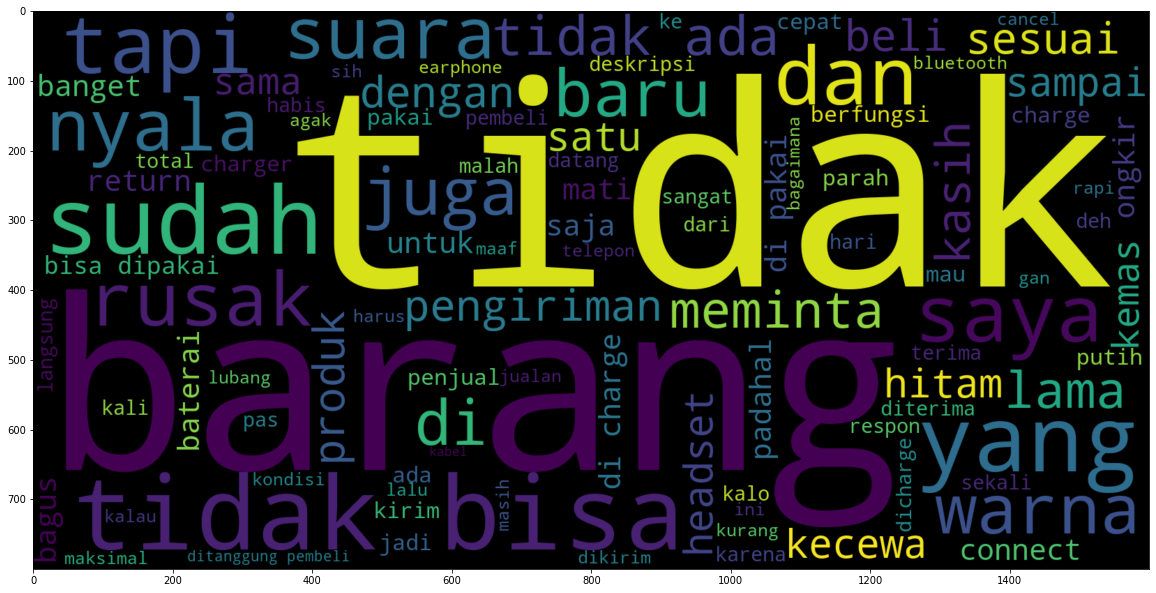

In [30]:
# sentimen negatif dengan stopword
plt.figure(figsize = (20,20)) 

w_cloud = WordCloud(background_color='black', min_font_size = 3,
                    max_words = 100 , width = 1600 ,
                    height = 800).generate(" ".join(negatif_prep))

plt.imshow(w_cloud,interpolation = 'bilinear')

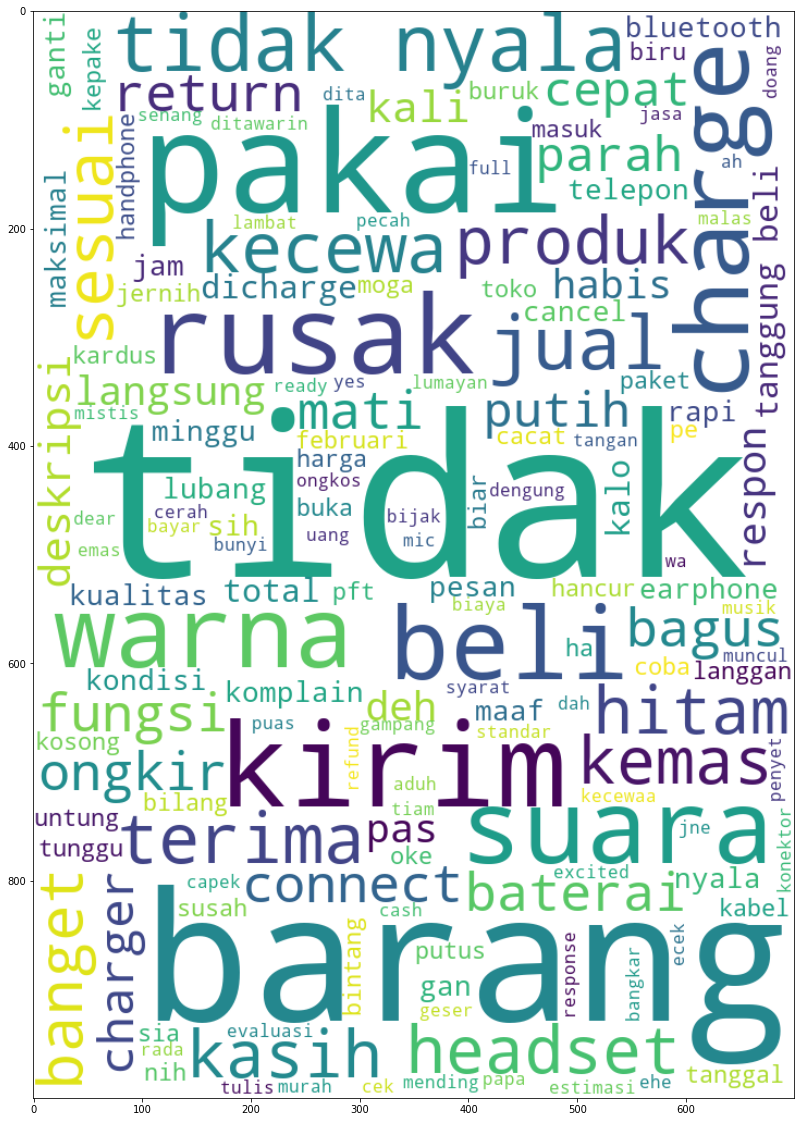

In [31]:
# sentimen negatif tanpa stopword
plt.figure(figsize = (20,20))

w_cloud = WordCloud(background_color='white', min_font_size = 3,
                    max_words = 150 , width = 700 ,
                    height = 1000).generate(" ".join(negatif_remv))

plt.imshow(w_cloud,interpolation = 'bilinear')

**Sentimen Netral**

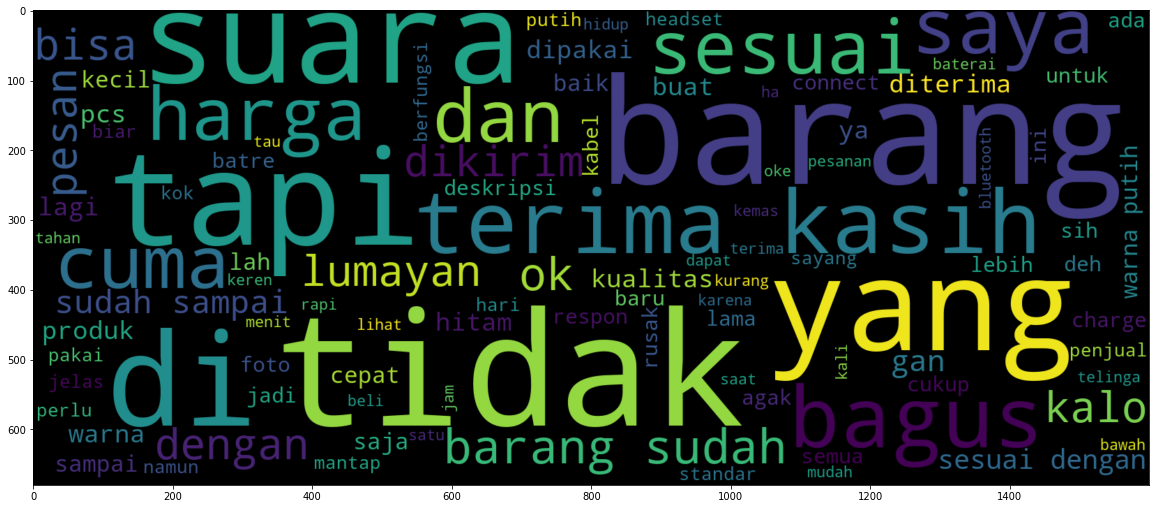

In [32]:
# sentimen netral dengan stopword
plt.figure(figsize = (20,20))

w_cloud = WordCloud(min_font_size = 3,  max_words = 100 ,
                    width = 1600 , height = 680).generate(" ".join(netral_prep))

plt.imshow(w_cloud,interpolation = 'bilinear')

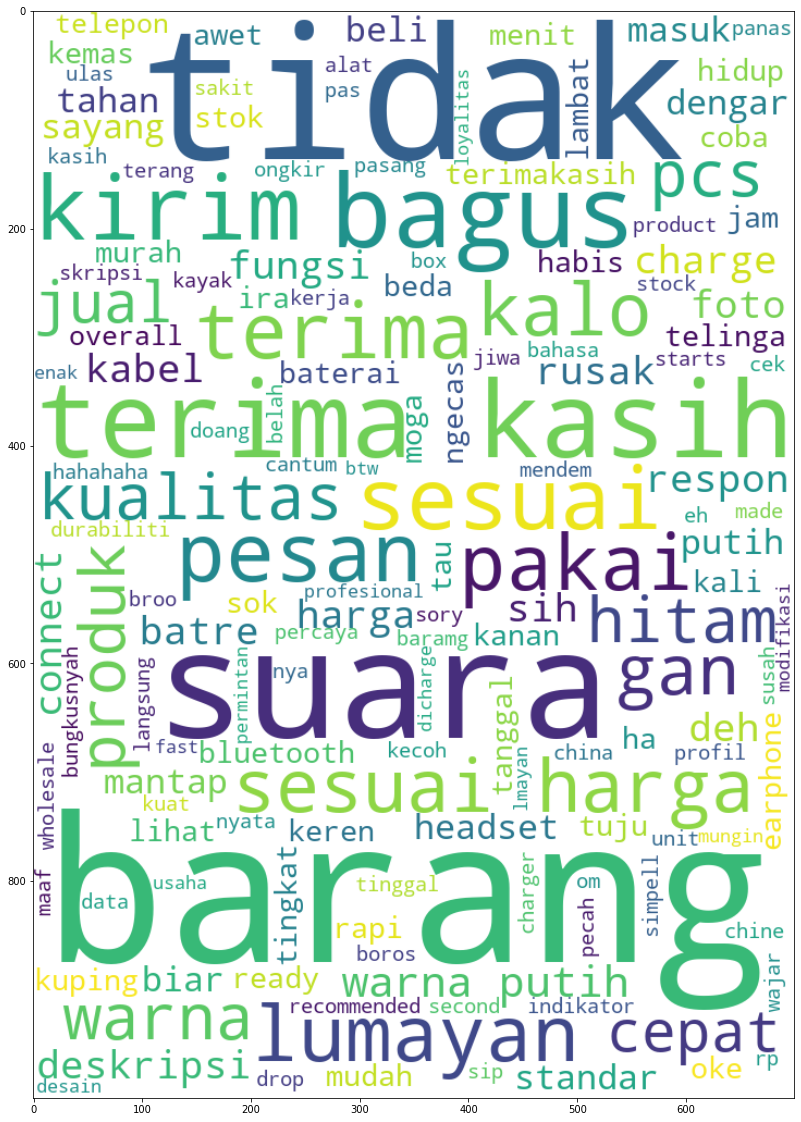

In [33]:
# sentimen netral tanpa stopword
plt.figure(figsize = (20,20)) 

w_cloud = WordCloud(background_color='white', min_font_size = 3,
                    max_words = 150 , width = 700 ,
                    height = 1000).generate(" ".join(netral_remv))

plt.imshow(w_cloud,interpolation = 'bilinear')
# plt.grid(None)

**Sentimen Positif**

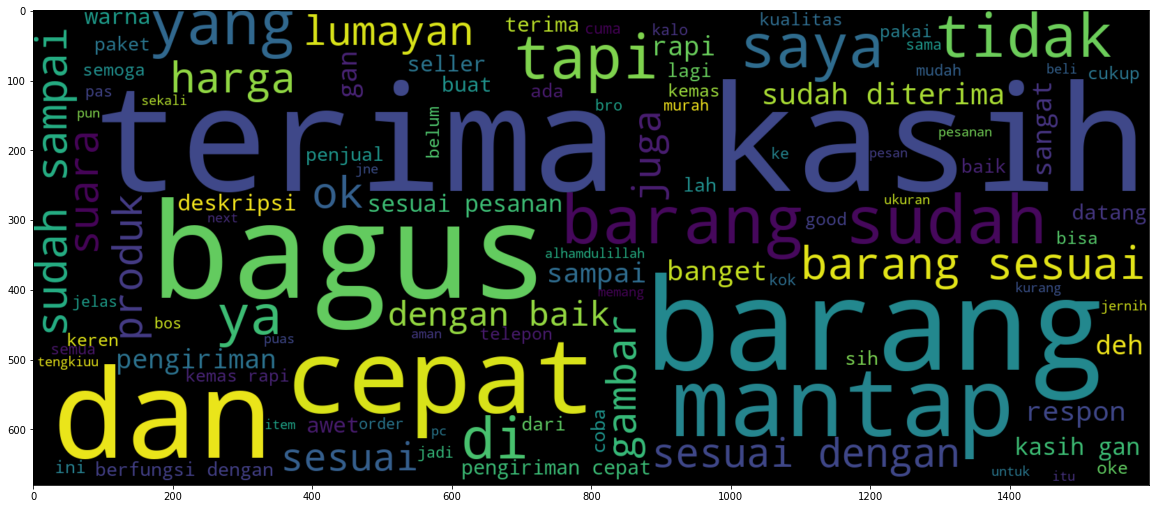

In [34]:
# sentimen positif dengan stopword
plt.figure(figsize = (20,20))

w_cloud = WordCloud(min_font_size = 3,  max_words = 100 ,
                    width = 1600 , height = 680).generate(" ".join(positif_prep))

plt.imshow(w_cloud,interpolation = 'bilinear')

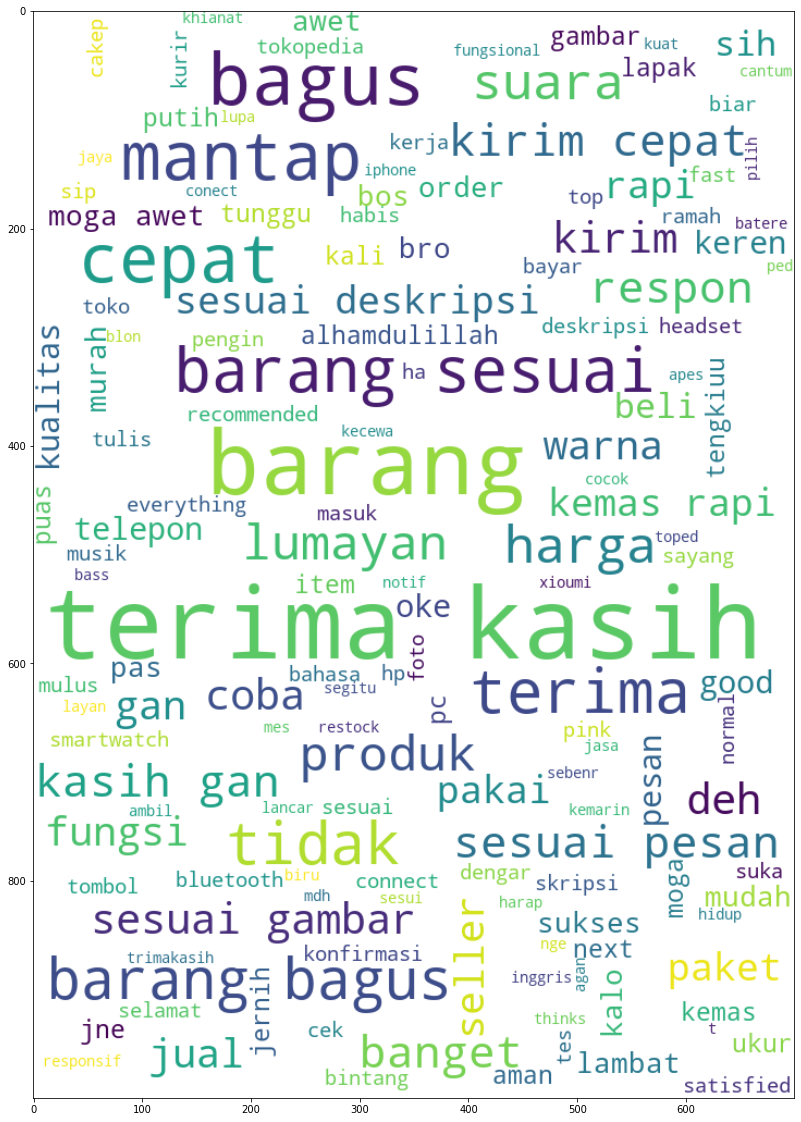

In [35]:
# sentimen positif tanpa stopword
plt.figure(figsize = (20,20)) 

w_cloud = WordCloud(background_color='white', min_font_size = 3,
                    max_words = 150 , width = 700 ,
                    height = 1000).generate(" ".join(positif_remv))

plt.imshow(w_cloud,interpolation = 'bilinear')

## **Extractive Summarization Using pre-trained BertModel**

PDF paper [Leveraging BERT for Extractive Text Summarization on Lectures](https://arxiv.org/ftp/arxiv/papers/1906/1906.04165.pdf).

Menggunakan model BERT untuk proses embedding dan melakukan clustering dengan K-Means untuk mengidentifikasi kalimat terdekat terhadap centroid yang selanjutnya akan dipilih sebagai kandidat kesimpulan.

In [36]:
BERTsumm = Summarizer()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# define function
def pre_train_BERTmodel(target, n, length_min):
    result = BERTsumm(target, num_sentences=n-1, min_length=length_min)
    full = ''.join(result)
    return tokenize.sent_tokenize(full)

**sentimen negatif**

In [38]:
# dengan stopword
BERT_neg_prep = pre_train_BERTmodel(target=join_neg_prep, n=5, length_min=10)
BERT_neg_prep

['earphone sih datang tapi tidak sama kabel sebelum di kemas di cek dulu ya terima kasih ehe.',
 'barang tidak bisa di charge lumayan kecewa.',
 'cacat produk tidak bisa nyala padahal baru beli.',
 'seperti penjual tidak mengecek kondisi barang sebelum dikirim barang yang saya terima tidak bisa charge karena lubang charge tidak pas dengan konektor.',
 'maaf saya kecewa dengan barang lubang charger geser jadi tidak bisa dipakai.']

In [39]:
# tanpa stopword
BERT_neg_remv = pre_train_BERTmodel(target=join_neg_remv, n=5, length_min=10)
BERT_neg_remv

['earphone sih tidak kabel kemas cek terima kasih ehe.',
 'barang rusak tidak suara connect malas komplain beli barang.',
 'maaf kecewa barang tidak sesuai deskripsi tidak telepon.',
 'barang rusak tidak pakai.',
 'emas tidak bagus kardus penyet.']

**sentimen netral**

In [40]:
# dengan stopword
BERT_net_prep = pre_train_BERTmodel(target=join_net_prep, n=5, length_min=10)
BERT_net_prep

['barang bagus tinggal lihat durabiliti.',
 'just ok sih batre tidak tahan lama suara ok saja.',
 'barang tidak sesuai foto tapi fungsi sama.',
 'barang sudah sampai tapi bungkus dari earphone berbeda dengan yang ditampilkan di halaman penjualan dan untuk earphone sendiri barang tiruan kenapa bisa beda yang gan penjual.',
 'ok terimakasih ini baru ok mengira bakal ngebas suara.']

In [41]:
# tanpa stopword
BERT_net_remv = pre_train_BERTmodel(target=join_net_remv, n=5, length_min=10)
BERT_net_remv

['barang bagus tinggal lihat durabiliti.',
 'sesuai harga.',
 'suara masuk tidak enak kuping mungin modifikasi desain.',
 'barang fungsi warna krim tidak sesuai pesan pesan hitam putih deskripsi hitam ready.',
 'tidak masuk telinga gan tuker tidak.']

**sentimen positif**

In [42]:
# dengan stopword
BERT_pos_prep = pre_train_BERTmodel(target=join_pos_prep, n=5, length_min=10)
BERT_pos_prep

['terima kasih.',
 'cepat banget sampai terima kasih.',
 'barang ok dicoba di dalam ruangan jelas suara.',
 'barang sudah diterima bagus tapi cepat banget habis.',
 'saya meminta cream tapi dikasih putih tapi afterall semua bagus dan cepat semoga makin berkah yang jual amin.']

In [43]:
# tanpa stopword
BERT_pos_remv = pre_train_BERTmodel(target=join_pos_remv, n=5, length_min=10)
BERT_pos_remv

['terima kasih.',
 'mantap banget suara banget terima kasih.',
 'barang sesui gambar kirim cepat kemas rapi.',
 'terima kasih paket terima.',
 'barang sesuai gambar terima kasih.']

## **Abstractive Summarization using pre-trained Pegasus**

PDF Paper: [PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization](https://arxiv.org/pdf/1912.08777.pdf).

pre-training menggunakan Gap Sentence Generation (GSG) dimana melakukan masking pada kalimat yang dianggap 'important' dan model ditugaskan untuk me-recover kalimat yang disembunyikan tersebut. 

In [44]:
mname = "google/pegasus-xsum"
pegasus = PegasusForConditionalGeneration.from_pretrained(mname)
tok = PegasusTokenizer.from_pretrained(mname)

In [45]:
# define function
def pre_train_Pegasus(target):
    batch = tok.prepare_seq2seq_batch(src_texts=target, return_tensors="pt")
    gen = pegasus.generate(**batch)
    return tok.batch_decode(gen, skip_special_tokens=True)

**sentimen negatif**

In [46]:
# dengan stopword
pegasus_neg_prep = pre_train_Pegasus(join_neg_prep)
pegasus_neg_prep

C:\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:3407: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


['Maelik barang rusak sudah sebuah sebuah kecewa, sebuah sebuah sebuah terbaik, sebuah sebuah terbaik, sebuah sebuah terbaik, sebu']

In [47]:
# dengan stopword
pegasus_neg_remv = pre_train_Pegasus(join_neg_remv)
pegasus_neg_remv

['Jogging barang rusak suara mala komplain beli barang pakai pakai pakai seriat sebuah sebuah serta sebuah sebuah sebuah sebuah serta sebuah s']

**sentimen netral**

In [48]:
# dengan stopword
pegasus_net_prep = pre_train_Pegasus(join_net_prep)
pegasus_net_prep

['pengirimpat stock barang bagus cuma suara kecil ada rusakua eh.']

In [49]:
# dengan stopword
pegasus_net_remv = pre_train_Pegasus(join_net_remv)
pegasus_net_remv

['Barang kirim sesuai harga sih sayang kirim warna putih ongkir gan suara.']

**sentimen positif**

In [50]:
# dengan stopword
pegasus_pos_prep = pre_train_Pegasus(join_pos_prep)
pegasus_pos_prep

['Mantap bagus cepat sampai pesanan sudahkai terlalu cukupus sama sudahkuatan walaukuatan selalu.']

In [51]:
# tanpa stopword
pegasus_pos_remv = pre_train_Pegasus(join_pos_remv)
pegasus_pos_remv

['Barang sesuai pesan paket rapi bagus suara lumayan suara lumayan bluetooth suara lumayan deskri barang gan terima kasih.']

Beberapa hal yang menjadi dugaan abstractive pre-trained model Pegasus tidak berkerja baik pada penelitian ini adalah:
1. Pre-training pada model menggunakan bahasa berbeda (inggris) yang mana memiliki perbedaan pola struktur kalimat serta vocabulary.
2. Bentuk data pada penelitian ini berupa kumpulan review yang sifatnya berulang atau minim variasi topik, berbeda dengan data yang digunakan dalam pre-training model.

## **Extractive Summarization with Cossine Similarity**

Dokumentasi dapat dilihat di [link](https://github.com/LaurentVeyssier/Unsupervised-Text-Summarizer-using-Extractive-method).

Menggunakan algoritma PageRank terhadap sentence berdasarkan word similarity yang didapatkan dari skor cossine distance.

In [76]:
def read_article(file_name):
    file = codecs.open(file_name, "r", encoding='cp1252', errors='replace')                   # handles accentuated characters
    filedata = file.readlines()
    article = filedata[0].split(". ")                                       # split the text by sentences using ". "
    
    sentences = []
    for sentence in article:                                                # iterate and generate list of wards for each sentence
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))     # replace any non character by " "
    
    return sentences

In [77]:
def sentence_similarity(sentence_1, sentence_2, stopwords=None):
    if stopwords is None:
        stopwords = []                              # create an empty list to avoid error below
 
    sentence_1 = [w.lower() for w in sentence_1]
    sentence_2 = [w.lower() for w in sentence_2]

    all_words = list(set(sentence_1 + sentence_2))  # create total vocabulary of unique words for the two sentences compared

    vector1 = [0] * len(all_words)                  # prepare one-hot vectors for each sentence over all vocab
    vector2 = [0] * len(all_words)

    # build the vector for the first sentence
    for w in sentence_1:
        if w in stopwords:
            continue 
        vector1[all_words.index(w)] += 1            # list.index(element) returns the index of the given element in the list

    # build the vector for the second sentence
    for w in sentence_2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return 1-cosine_distance(vector1, vector2)      # Cosine = 0 for similar sentences => returns 1 if perfectly similar

In [78]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))  # create a square matrix with dim the num of sentences
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:                                        # ignore if both are same sentences (diagonal of the square matrix)
                continue
            # similarity of each sentence to all other sentences in the text is measured and logged in the matrix
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [79]:
def generate_summary(file_name, top_n=5, show=False):
    #stop_words = stopwords.words('english')
    stop_words = stopwords.words('indonesian')
    summarize_text = []
    
    # Step 1 - Read text and tokenize
    sentences =  read_article(file_name)
    print("number of sentences in text : ", len(sentences))
    
    # Step 2 - Generate Similary Matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)
    
    # Step 3 - Rank sentences in similarity matrix. let’s convert the similarity matrix into a graph. 
    # The nodes of this graph will represent the sentences and the edges will represent the similarity scores between
    # the sentences. On this graph, we will apply the PageRank algorithm to arrive at the sentence rankings.
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
    
    # Step 4 - Sort the rank and pick top sentences extract the top N sentences based on their rankings for summary generation
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    if show :
        print("Indexes of top ranked_sentence order are ", ranked_sentence)
    # extract the top N sentences based on their rankings for summary generation
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    
    # Step 5 - Output the summarize text
    print("Summarize Text:\n",".\n".join(summarize_text)+'.')

**sentimen negatif**

In [56]:
# dengan stopword
generate_summary('join_neg_prep.txt', top_n=5, show=False)

number of sentences in text :  82
Summarize Text:
 barang rusak tidak ada suara padahal sudah connect malas komplain karena beli dengan barang lain.
barang tidak sampai sama sekali.
barang sudah connect tapi tidak keluar suara.
barang tidak berfungsi.
barang rusak tidak bisa dipakai.


In [57]:
# tanpa stopword
generate_summary('join_neg_remv.txt', top_n=5, show=False)

number of sentences in text :  82
Summarize Text:
 barang rusak tidak pakai.
barang rusak tidak suara connect malas komplain beli barang.
barang bagus beli minggu rusak tidak pakai.
barang pakai mati rusak.
barang tidak.


**sentimen netral**

In [58]:
# dengan stopword
generate_summary('join_net_prep.txt', top_n=5, show=False)

number of sentences in text :  91
Summarize Text:
 barang sesuai dengan gambar terima kasih.
barang sudah di tiba terima kasih.
barang sudah diterima terima kasih.
kualitas barang sesuai harga.
kualitas barang sesuai dengan harga.


In [59]:
# tanpa stopword
generate_summary('join_net_remv.txt', top_n=5, show=False)

number of sentences in text :  91
Summarize Text:
 barang terima kasih.
barang sesuai gambar terima kasih.
barang terima terima kasih.
terima kasih barang coba.
terima kasih you barang.


**sentimen positif**

In [60]:
# dengan stopword
generate_summary('join_pos_prep.txt', top_n=5, show=False)

number of sentences in text :  160
Summarize Text:
 terima kasih barang bagus.
sesuai deskripsi barang bagus kemas cukup rapi terima kasih.
jumlah barang sesuai mdh bagus dan awet terima kasih.
barang sudah sampai dan sesuai dengan pesanan terima kasih.
barang sudah sesuai dengan gambar terima kasih.


In [61]:
# tanpa stopword
generate_summary('join_pos_remv.txt', top_n=5, show=False)

number of sentences in text :  160
Summarize Text:
 terima kasih barang bagus.
barang sesuai pesan terima kasih.
barang sesuai gambar terima kasih.
barang cepat terima kasih.
sesuai deskripsi barang bagus kemas rapi terima kasih.


Salah satu kekurangan pada algoritma ini ialah terdapat keterbatasan pada, diduga antara, jumlah variasi kata maupun jumlah kata dalam kalimat yang menyebabkan model tak dapat menyelesaikan proses iterasi dalam perhitungan. Jalan keluar yang diambil sejauh ini ialah dengan melakuka random under-sampling dengan cara resample data untuk mendapatkan 160 entry.

Berdasarkan uji yang telah dilakukan, ditentukan:
1. tahpan preprocessing yang dilakukan terbatas hingga menghilkan karakter yang tidak diperlukan serta transformasi kata tidak baku menjadi bentuk formal, tanpa menghilangkan stopword. Hal ini bertujuan agar hasil pengambilan kesimpulan tetap dapat terbaca dengan mudah.
2. Algoritma TextRank Similarity ditentukan sebagai model terpilih.

## **MODEL INFERENCE**

In [62]:
def remove_empty(df):
    df['preprocessed'] = df['preprocessed'].replace('',np.nan)
    df.dropna(inplace=True)
    return df

In [63]:
def read_text(file):
    input = file.split(". ")
    teks = []
    for kalimat in input:
        teks.append(kalimat.split(" "))
    return teks

In [64]:
def sentence_similarity(sentence_1, sentence_2, stopwords=None):
    if stopwords is None:
        stopwords = []                              # create an empty list to avoid error below
 
    sentence_1 = [w.lower() for w in sentence_1]
    sentence_2 = [w.lower() for w in sentence_2]

    all_words = list(set(sentence_1 + sentence_2))  # create total vocabulary of unique words for the two sentences compared

    vector1 = [0] * len(all_words)                  # prepare one-hot vectors for each sentence over all vocab
    vector2 = [0] * len(all_words)

    # build the vector for the first sentence
    for w in sentence_1:
        if w in stopwords:
            continue 
        vector1[all_words.index(w)] += 1            # list.index(element) returns the index of the given element in the list

    # build the vector for the second sentence
    for w in sentence_2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return 1-cosine_distance(vector1, vector2)      # Cosine = 0 for similar sentences => returns 1 if perfectly similar

In [65]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))  # create a square matrix with dim the num of sentences
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:                                        # ignore if both are same sentences (diagonal of the square matrix)
                continue
            # similarity of each sentence to all other sentences in the text is measured and logged in the matrix
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [66]:
def generate_summary(file_name, top_n=5, show=False):
    #stop_words = stopwords.words('english')
    stop_words = stopwords.words('indonesian')
    summarize_text = []
    
    # Step 1 - Read text and tokenize
    sentences =  read_text(file_name)
    print("number of sentences in text : ", len(sentences))
    
    # Step 2 - Generate Similary Matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(sentences, stop_words)
    
    # Step 3 - Rank sentences in similarity matrix. let’s convert the similarity matrix into a graph. 
    # The nodes of this graph will represent the sentences and the edges will represent the similarity scores between
    # the sentences. On this graph, we will apply the PageRank algorithm to arrive at the sentence rankings.
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
    
    # Step 4 - Sort the rank and pick top sentences extract the top N sentences based on their rankings for summary generation
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    if show :
        print("Indexes of top ranked_sentence order are ", ranked_sentence)
    # extract the top N sentences based on their rankings for summary generation
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    
    # Step 5 - Output the summarize text
    print("Summarize Text:\n",".\n".join(summarize_text)+'.')
    
    #teks = ". ".join(summarize_text)
    #return tokenize.sent_tokenize(teks)

In [67]:
# 1. input data
df_nokia = df[df.product_name=='NOKIA 130 dual sim handphone hp']
df_nokia = df_nokia[['product_name', 'text', 'rating']].reset_index(drop=True)
df_nokia.sample(10)

,product_name,text,rating
343,NOKIA 130 dual sim handphone hp,Respon cepat. . .. . . . . . . . . . .,4
602,NOKIA 130 dual sim handphone hp,"Barang sdh diterima dgn kondisi baik, thx gan...",4
427,NOKIA 130 dual sim handphone hp,"alhmdulilah barang oke ,semoga awet aamiiin",5
150,NOKIA 130 dual sim handphone hp,Mantap pokoknyaa sesuai,5
549,NOKIA 130 dual sim handphone hp,terimakasih barang sampai dgn baik hx sja kuri...,4
370,NOKIA 130 dual sim handphone hp,Niceeeeeeeeeeeeeeeeeeeeee,5
569,NOKIA 130 dual sim handphone hp,Barang sampai aman dan packing rapi sekali,5
436,NOKIA 130 dual sim handphone hp,Mantaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,5
342,NOKIA 130 dual sim handphone hp,Hp mati saat penggunaan pertama...dan gak mau ...,2
447,NOKIA 130 dual sim handphone hp,Koj batre nya boros banget yak. Ama sinyal ga...,1


In [68]:
# 2. create new label: sentiment
df_nokia['sentimen'] = df_nokia['rating'].replace({1:0, 2:0, 3:1, 4:2, 5:2})

In [69]:
# 3. remove unnecessary character and transform word to its common form
cleaner(df_nokia)
df_nokia = remove_empty(df_nokia)
df_nokia.sample(10)

,product_name,text,rating,sentimen,preprocessed
263,NOKIA 130 dual sim handphone hp,Lumayan dengan harga segitu,3,1,lumayan dengan harga segitu
296,NOKIA 130 dual sim handphone hp,"Packing rapi, pengiriman sesuai dgn estimasi y...",5,2,kemas rapi pengiriman sesuai dengan estimasi y...
300,NOKIA 130 dual sim handphone hp,Barang nya bgus dan packing nya rapi makasihh,5,2,barang bagus dan kemas rapi makasihh
190,NOKIA 130 dual sim handphone hp,Beli 5 unit hp disini ga ada yg satupun yg bgu...,1,0,beli unit hp disini tidak ada yang satupun yan...
560,NOKIA 130 dual sim handphone hp,Hp jadul kondis baru ini dapat berfungsi sebag...,3,1,hp jadul kondis baru ini dapat berfungsi sebag...
605,NOKIA 130 dual sim handphone hp,Barang sudah sampai terima kasih....,3,1,barang sudah sampai terima kasih
610,NOKIA 130 dual sim handphone hp,maaf barang untuk slot simcard 1 tdk bisa kone...,1,0,maaf barang untuk slot simcard tidak bisa conn...
557,NOKIA 130 dual sim handphone hp,Kecewa berat. Lebih layak jadi HP mainan,1,0,kecewa berat lebih layak jadi hp mainan
283,NOKIA 130 dual sim handphone hp,"Bagus HP nya,,, sesuai pesanan",5,2,bagus hp sesuai pesanan
454,NOKIA 130 dual sim handphone hp,Lumayan diliat sama buat tlpluamayan dah tpi k...,3,1,lumayan dilihat sama buat tlpluamayan deh tapi...


In [70]:
negatif_inf = df_nokia[df_nokia.sentimen==0]['preprocessed']
netral_inf = df_nokia[df_nokia.sentimen==1]['preprocessed']
positif_inf = df_nokia[df_nokia.sentimen==2]['preprocessed'].sample(160)

join_neg_inf = '. '.join(list(negatif_inf.values))
join_net_inf = '. '.join(list(netral_inf.values))
join_pos_inf = '. '.join(list(positif_inf.values))

In [71]:
generate_summary(join_neg_inf, top_n=5, show=False)

number of sentences in text :  80
Summarize Text:
 batre hp cepat habis alias boros.
hp ringkih gampang rusak antara hp nokia atau replika.
hp mati tidak bisa digunakan.
kelamaan pengiriman barang.
hp gampang mati sendiri amp saya ta ternyata rekondisi cuma ganti kesing barang bukan orisinal nokia charger maupun baterai semoga sukses jualan.


In [72]:
generate_summary(join_net_inf, top_n=5, show=False)

number of sentences in text :  86
Summarize Text:
 respon ya agak lama barang sesuai harga.
barang sesuai gambar terima kasih.
sesuai harga harga murah barang juga lumayan sesuai harga harga murah barang juga lumayan.
ok barang lumayan sesuai dengan harga.
pengiriman lambretta barang ya sesuai harga ya.


In [73]:
generate_summary(join_pos_inf, top_n=5, show=False)

number of sentences in text :  160
Summarize Text:
 barang sesuai pesanan terima kasih.
barang di terima sesuai pesanan pengiriman cepat.
barang sesuai pesanan dan bagus.
barang bagus sesuai pesanan.
barang sesuai pesanan dan deskripsi terima kasih.


## **CONCLUSION**

Pada notebook ini telah dilakukan proses pengolahan untuk mendapatkan summarization dari produk review di Tokopedia. Adapun tahapan yang dilakukan ialah:
1. Input File: Berupa file dengan format `.csv` yang berisikan 2 kolom yaitu `text` dan `rating`
2. Proses Preprocessing: Meliputi pembuatan label sentimen berdasarkan rating, menghilangkan karakter yang tidak dibutuhkan serta melakukan trasformasi kata yang tidak umum menjadi bentuk formal, dan menghilangka kata imbuhan serta kata sambung (stopword).
3. Summarization: Menggunakan 3 algoritma dalam pengujian yaitu extractive pre-trained BERTmodel, abstractive pre-trained Pegasus, dan extractive TextRank Similarity.

Berdasarkan pengujian yang dilakukan diputuskan algoritma/model terpilih ialah algoritma extractive TextRank Similarity.

Pengujian inference dilakukan terhadap data review produk yang berbeda.

Kesulitan yang terdapat sepanjang mengerjakan notebook ini ialah keterbatasan dalam melakukan proses evaluasi dalam membandingkan hasil terbaik antara pre-trained BERTmodel dengan TextRank similarity. Pada akhirnya TextRank similarity dinyatakan sebagai model terpilih meskipun memiliki keterbatasan dalam jumlah variasi kata yang dapat diproses. Hal tersebut didasarkan karena konsistensi kemiripan hasil antara kelompok dengan stopword dan tanpa stopword. Peneliti menyadari penilaian ini bersifat sangat relatif dan terbuka akan diskusi serta masukan.